## CNN 스팸 메일 분류

### 데이터 로드 및 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


* https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

In [3]:
import urllib.request

urllib.request.urlretrieve('https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv', filename = 'spam.csv')
data = pd.read_csv('spam.csv', encoding = 'latin-1')
print(len(data))

5572


In [5]:
data[data.v1 == 'spam']

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",NaN,NaN,NaN
...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,NaN,NaN,NaN
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,NaN,NaN,NaN
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,NaN,NaN,NaN
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,NaN,NaN,NaN


In [7]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])    # 0, 1로 변환시켜줄게
data[:10] 

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [8]:
data.drop_duplicates(subset = ['v2'], inplace = True)
len(data)
# 떨궈졌구나

5169

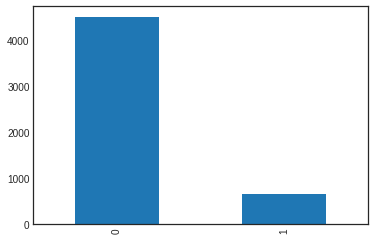

In [9]:
plt.style.use('seaborn-white')
data['v1'].value_counts().plot(kind = 'bar')


In [10]:
data['v1'].value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [12]:
data.groupby('v1').size().reset_index(name = 'count')   # 인덱스의 이름을 바꿔줄게
#정상메일 4500
#스펨 650

# 생각ㅂ다 많구나..

,v1,count
0,0,4516
1,1,653


In [13]:
X_data = data['v2']
y_data = data['v1']


In [17]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)   # 1000개씩
tokenizer.fit_on_texts(X_data)  # 5196개를 token화 하는거지

sequences = tokenizer.texts_to_sequences(X_data) # index값을 가지게 되겠지



In [20]:
sequences[:5]
#5개만 출력해볼게

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6],
 [53,
  537,
  8,
  20,
  4,
  934,
  2,
  220,
  706,
  267,
  70,
  2,
  2,
  359,
  537,
  604,
  82,
  436,
  185,
  707,
  437],
 [6, 226, 152, 23, 347, 6, 138, 145, 56, 152],
 [935, 1, 97, 96, 69, 453, 2, 877, 69, 198, 105, 438]]

In [21]:
X_data = sequences

print('메일 최대 길이: {}'.format(max(len(l) for l in X_data)))#메일의 길이를 체크해볼게
print('메일 평균 길이: {}'.format((sum(map(len, X_data))/len(X_data)))) # map으로 len xdata펼쳐주고 평균 나눠줘야지

메일 최대 길이: 172
메일 평균 길이: 12.566840781582512


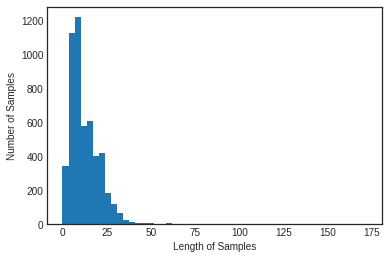

In [22]:
plt.hist([len(s) for s in X_data], bins = 50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

# 뭐 정말 특이케이스인 175가 있지만 분포가 거의 없으니 60에서 잘라보자


In [23]:
max_len = 60
data = pad_sequences(X_data, maxlen = max_len)
print(data.shape)   # 60으로 패딩한 값으로 채웠어

(5169, 60)


In [24]:
# test랑 train이랑 구분해야지

n_train = int(len(sequences) * 0.8)
n_test = int(len(sequences) - n_train)

print(n_train)  # 5169개를 80%, 20%로 구분했지
print(n_test)

4135
1034


In [28]:
np.array(y_data[0])
data[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  47, 433, 780, 705, 662,  64,
         8,  94, 121, 434, 142,  68,  57, 137], dtype=int32)

In [29]:
X_train = data[:n_train]
y_train = np.array(y_data[:n_train])

X_test = data[n_train:]
y_test = np.array(y_data[n_train:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


### 모델 구성

In [30]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [32]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32,5, strides = 1, padding = 'valid', activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [35]:
es = EarlyStopping(monitor = 'val_loss',
                   mode ='min',
                   verbose = 1,
                   patience = 3)
mc = ModelCheckpoint('best_model.h5', moniter = 'val_acc', mode = 'max',
                     verbose = 1, save_best_only= True)

### 모델 학습

In [36]:
history = model.fit(X_train,y_train,
                    epochs = 10,
                    batch_size = 64,
                    validation_split = 0.2,
                    callbacks = [es, mc])

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.4635 - acc: 0.8694
Epoch 00001: val_loss improved from -inf to 0.38254, saving model to best_model.h5
52/52 [==============================] - 0s 8ms/step - loss: 0.4635 - acc: 0.8694 - val_loss: 0.3825 - val_acc: 0.8730
Epoch 2/10
43/52 [=======================>......] - ETA: 0s - loss: 0.3737 - acc: 0.8695
Epoch 00002: val_loss did not improve from 0.38254
52/52 [==============================] - 0s 4ms/step - loss: 0.3670 - acc: 0.8697 - val_loss: 0.3109 - val_acc: 0.8730
Epoch 3/10
44/52 [========================>.....] - ETA: 0s - loss: 0.1966 - acc: 0.9190
Epoch 00003: val_loss did not improve from 0.38254
52/52 [==============================] - 0s 4ms/step - loss: 0.1831 - acc: 0.9287 - val_loss: 0.0879 - val_acc: 0.9843
Epoch 4/10
45/52 [========================>.....] - ETA: 0s - loss: 0.0550 - acc: 0.9858
Epoch 00004: val_loss did not improve from 0.38254
52/52 [==============================] - 0s 4ms/ste

### 시각화

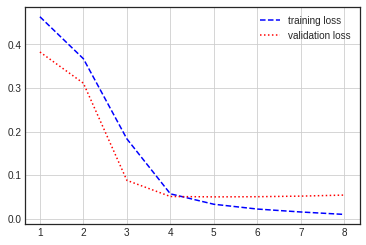

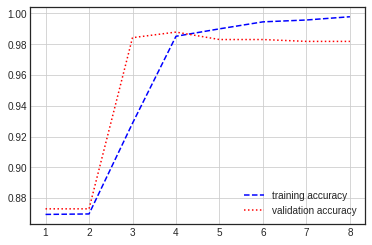

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs , loss, 'b--', label = 'training loss')
plt.plot(epochs , val_loss, 'r:', label = 'validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs , acc, 'b--', label = 'training accuracy')
plt.plot(epochs , val_acc, 'r:', label = 'validation accuracy')
plt.grid()
plt.legend()

# 음 이정도면 굉장하군!
# overfitting도 안되고!

In [40]:
model.evaluate(X_test,y_test)

# 98퍼라니 ㅆㅅㅌㅊ

33/33 [==============================] - 0s 2ms/step - loss: 0.0680 - acc: 0.9816


[0.06803438067436218, 0.9816247820854187]